In [1]:
from quickdb.sqlhttp import sqlclient

### Count

In [71]:
sql = '''
SELECT count(*) from pdr2_wide
'''

%time res = sqlclient.post_sql(sql)

CPU times: user 3.68 ms, sys: 2.55 ms, total: 6.23 ms
Wall time: 47.6 ms


In [72]:
res.dataframe()

,$group_by,col0
0,None,712123431


### Histogram

#### 1D


100%|██████████| 128/128 [00:01<00:00, 115.29it/s]

CPU times: user 67.2 ms, sys: 21.4 ms, total: 88.6 ms
Wall time: 1.12 s


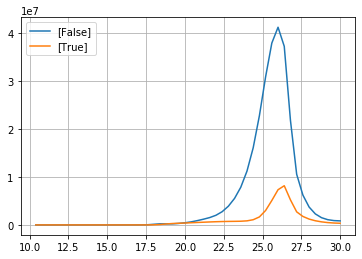

In [69]:
sql = '''
SELECT
    histogram(forced.i.psfflux_mag, range => (10, 30), bins => 50)
FROM
    pdr2_wide
WHERE
    forced.isprimary
GROUP BY
    forced.i.extendedness_value < 0.5
'''

%time res = sqlclient.post_sql_with_tqdm(sql)

from matplotlib import pyplot

for group, (hist, bins) in zip(*res.target_list):
    pyplot.plot(bins[1:], hist, label=group)
    
pyplot.grid()
pyplot.legend()

#### 2D

100%|██████████| 128/128 [00:01<00:00, 110.71it/s]

CPU times: user 45 ms, sys: 22.5 ms, total: 67.5 ms
Wall time: 1.16 s


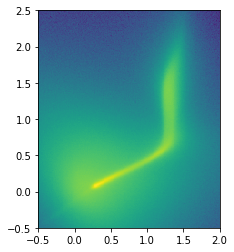

In [75]:
sql = '''
SELECT
    histogram2d(
        forced.g.psfflux_mag - forced.r.psfflux_mag,
        forced.r.psfflux_mag - forced.i.psfflux_mag,
        bins => (200, 400), range => ((-0.5, 2.), (-0.5, 2.5)))
FROM
    pdr2_wide
WHERE
    forced.i.extendedness_value < 0.5
'''

%time res = sqlclient.post_sql_with_tqdm(sql)

import numpy
hist, xedges, yedges = res.target_list[1][0]
pyplot.imshow(numpy.log(1 + hist).T, origin='low', extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]))

### Streaming

In [74]:
sql = '''
    SELECT object_id from pdr2_dud
'''

count = 0
for batch in sqlclient.post_sql_streaming_with_tqdm(sql):
    count += len(batch[0])
    
count

100%|██████████| 128/128 [00:02<00:00, 48.58it/s]


32818438

### Crossmatch

In [ ]:
import numpy

def gen_coord(n):
    a0 = 330
    a1 = 370
    d0 = -1
    d1 = +2.5
    r = numpy.random.uniform(a0, a1, n)
    d = numpy.random.uniform(d0, d1, n)
    return numpy.array([r, d])

my_cat = gen_coord(10000)

In [ ]:
import hscmap
w = hscmap.Window()

In [ ]:
w.catalogs.clear()
w.catalogs.new(*my_cat, color=[0, 1, 0, 0.25])

In [ ]:
sql = f'''
SELECT
    crossmatch(
        forced.coord,             -- reference catalog
        shared.my_cat / degree,   -- user's catalog [radian]
        5 / arcsec,               -- match radius   [radian]
        forced.coord_ra * degree,
        forced.coord_dec * degree
    )
FROM
    pdr2_wide
WHERE
    forced.isprimary AND forced.i.psfflux_mag < 25.
'''

%time res = sqlclient.post_sql_with_tqdm(sql, shared={'my_cat': my_cat})

In [ ]:
my_cat_indices, (ra, dec) = res.target_list[1][0]

In [ ]:
w.catalogs.new(ra, dec, color=[1, 0, 0, 0.25])